In [17]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import functions as f 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
%matplotlib inline

In [16]:
print('Hello')

Hello


In [18]:
def clean_data(df, y_label):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    
    # 3. Create y as the Salary column
    y = df[y_label]
    
    # 4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    df = df.drop([y_label], axis=1)
    
    # 6. Create dummy columns for all the categorical variables in X, drop the original columns
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)

    X = df
    return X, y
    


In [19]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True, lm_model=DecisionTreeRegressor(min_samples_split=40, max_depth=500), metric=r2_score):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        print(cutoff)
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(metric(y_test, y_test_preds))
        r2_scores_train.append(metric(y_train, y_train_preds))
        results[str(cutoff)] = metric(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.abs().sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    #lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test



In [20]:
df = pd.read_pickle('data/rent_cleaned.pkl')

In [21]:
df.columns

Index(['obid', 'mietekalt', 'nebenkosten', 'heizkosten', 'baujahr',
       'letzte_modernisierung', 'wohnflaeche', 'nutzflaeche', 'etage',
       'anzahletagen', 'zimmeranzahl', 'schlafzimmer', 'badezimmer',
       'ev_kennwert', 'laufzeittage', 'hits', 'click_schnellkontakte',
       'click_customer', 'click_weitersagen', 'click_url', 'aufzug', 'balkon',
       'einbaukueche', 'ev_wwenthalten', 'foerderung', 'gaestewc', 'garten',
       'heizkosten_in_wm_enthalten', 'keller', 'parkplatz', 'rollstuhlgerecht',
       'ausstattung', 'energieeffizienzklasse', 'energieausweistyp',
       'haustier_erlaubt', 'heizungsart', 'kategorie_Wohnung', 'objektzustand',
       'kid2019', 'ags2019', 'anbieter', 'spell', 'adat', 'edat', 'rent_sqm',
       'City', 'Wärmezufuhr', 'Erdgas leicht', 'Erdgas schwer',
       'keine Information', 'Windenergie', 'Pellets', 'Solarenergie', 'Koks',
       'kombinierte erneuerbare Energie', 'Erdwärme', 'Bioenergie',
       'Wasserenergie', 'Nahwärme', 'Fernwärme',

In [22]:
df.shape

(2651885, 73)

### Columns used for regression

In [23]:
y_columns = ['nebenkosten', 'ev_kennwert']
X_columns = ['baujahr', 'City', 'year', 'ev_wwenthalten',
       'letzte_modernisierung', 'wohnflaeche', 'etage',
       'anzahletagen', 'zimmeranzahl', 'schlafzimmer', 'badezimmer',
       'aufzug', 'balkon',
       'einbaukueche', 'gaestewc', 'garten',
       'keller', 'parkplatz', 'rollstuhlgerecht',
       'kategorie_Wohnung', 'objektzustand', 'heizungsart', 'heizkosten_in_wm_enthalten', 
       'Wärmezufuhr', 'Erdgas leicht', 'Erdgas schwer',
       'keine Information', 'Windenergie', 'Pellets', 'Solarenergie', 'Koks',
       'kombinierte erneuerbare Energie', 'Erdwärme', 'Bioenergie',
       'Wasserenergie', 'Nahwärme', 'Fernwärme', 'Holzschnitzel', 'Öl',
       'kombinierte regenerative Energie', 'Kohle',
       'kombinierte Fossilkraftstoffe', 'Gas', 'Holz', 'Heizdampf-Fernwärme',
       'thermische Umweltenergie', 'Flüssiggas', 'kombinierte Bio Energie',
       'Elektro']

columns_ev_kennwert = X_columns + [y_columns[1]]
columns_baujahr = ['baujahr', 'City', 'year', 'ev_wwenthalten', 'wohnflaeche', 'etage',
       'anzahletagen', 'zimmeranzahl', 'schlafzimmer', 'badezimmer',
       'aufzug', 'balkon',
       'einbaukueche', 'gaestewc', 'garten',
       'keller', 'parkplatz', 'rollstuhlgerecht',
       'kategorie_Wohnung', 'objektzustand', 'heizungsart', 'heizkosten_in_wm_enthalten', 
       'Wärmezufuhr', 'Erdgas leicht', 'Erdgas schwer',
       'keine Information', 'Windenergie', 'Pellets', 'Solarenergie', 'Koks',
       'kombinierte erneuerbare Energie', 'Erdwärme', 'Bioenergie',
       'Wasserenergie', 'Nahwärme', 'Fernwärme', 'Holzschnitzel', 'Öl',
       'kombinierte regenerative Energie', 'Kohle',
       'kombinierte Fossilkraftstoffe', 'Gas', 'Holz', 'Heizdampf-Fernwärme',
       'thermische Umweltenergie', 'Flüssiggas', 'kombinierte Bio Energie',
       'Elektro']

# Regression Baujahr

In [24]:
regression_baujahr = df[columns_baujahr]

In [25]:
idx = regression_baujahr[regression_baujahr.baujahr.isnull()].index

In [26]:
regression_baujahr.dropna(subset=['baujahr'], inplace=True)

<ipython-input-26-436b13a550da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_baujahr.dropna(subset=['baujahr'], inplace=True)


In [27]:
regression_baujahr.shape

(1682820, 48)

In [28]:
X, y = clean_data(regression_baujahr, 'baujahr')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [30]:
%%time
clf = DecisionTreeRegressor(min_samples_split=40, max_depth=500)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(r2_score(y_test, prediction))

0.5131187850290612
CPU times: user 23.5 s, sys: 1.49 s, total: 25 s
Wall time: 25.3 s


In [31]:
feature_importance = pd.DataFrame(clf.feature_importances_, X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

In [32]:
feature_importance.head(5)

,importance
objektzustand_Erstbezug,0.129292
wohnflaeche,0.108783
heizungsart_Etagenheizung,0.080065
objektzustand_Neuwertig,0.068545
anzahletagen,0.067319


In [33]:
prediction_baujahr = df.loc[idx, columns_baujahr]

In [34]:
X_pred, _ = clean_data(prediction_baujahr, 'baujahr')

In [35]:
prediction = clf.predict(X_pred)

prediction_baujahr.baujahr = prediction

In [36]:
len(prediction)

969065

In [37]:
idx = prediction_baujahr.index

In [38]:
idx.shape

(969065,)

In [39]:
df.loc[idx, 'baujahr'] = prediction_baujahr.baujahr

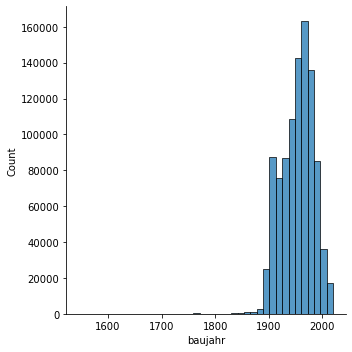

In [40]:
sns.displot(data=prediction_baujahr, x='baujahr', bins=40)

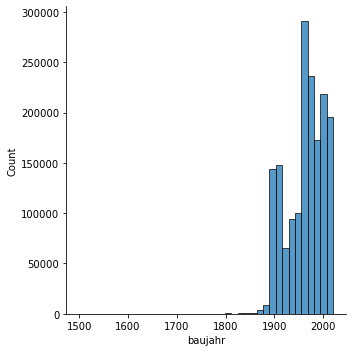

In [41]:
sns.displot(data=regression_baujahr, x='baujahr', bins=40)

In [42]:
full_baujahr = pd.concat([prediction_baujahr, regression_baujahr], axis=0)

In [43]:
prediction_baujahr.shape, regression_baujahr.shape, full_baujahr.shape

((969065, 48), (1682820, 48), (2651885, 48))

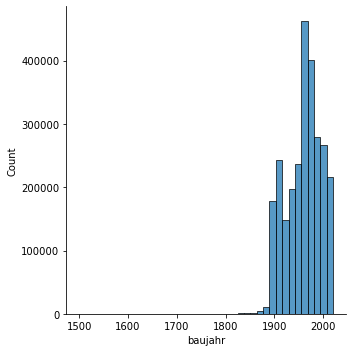

In [44]:
sns.displot(data=full_baujahr, x= 'baujahr', bins=40)

## Regression ev_kennwert
Build a regression model based on the predicted baujahr dataframe

In [45]:
idx = full_baujahr.index

regression_ev_kennwert = df.loc[:,columns_ev_kennwert]

df.shape, regression_ev_kennwert.shape

((2651885, 73), (2651885, 50))

In [46]:
idx = regression_ev_kennwert[regression_ev_kennwert.ev_kennwert == -100].index


In [47]:
regression_ev_kennwert.drop(index=idx, inplace=True)

In [48]:
regression_ev_kennwert.letzte_modernisierung.fillna(regression_ev_kennwert.baujahr, inplace=True)

In [49]:
X, y = clean_data(regression_ev_kennwert, 'ev_kennwert')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [51]:
%%time
clf = DecisionTreeRegressor(min_samples_split=80, max_depth=4000)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(r2_score(y_test, prediction))

0.4141576932855313
CPU times: user 11.5 s, sys: 620 ms, total: 12.1 s
Wall time: 12.2 s


In [52]:
prediction_ev_kennwert = df.loc[idx, columns_ev_kennwert]

In [53]:
prediction_ev_kennwert.letzte_modernisierung.fillna(prediction_ev_kennwert.baujahr, inplace=True)

In [54]:
prediction_ev_kennwert.dropna(subset=['letzte_modernisierung', 'baujahr'], inplace=True)

In [55]:
X_pred, _ = clean_data(prediction_ev_kennwert, 'ev_kennwert')

In [56]:
prediction = clf.predict(X_pred)

prediction_ev_kennwert.ev_kennwert = prediction

In [57]:
clf.feature_importances_

array([5.11416224e-01, 1.87880997e-02, 7.10894288e-03, 5.01094299e-02,
       6.75619365e-02, 1.94421133e-02, 3.53468886e-02, 1.17831754e-02,
       8.30695441e-03, 8.78926844e-03, 1.10084950e-02, 6.91771571e-03,
       6.72230154e-03, 2.71234019e-03, 4.28465434e-03, 7.72661088e-03,
       1.59842632e-03, 0.00000000e+00, 7.11931436e-03, 3.80172304e-05,
       6.45493909e-04, 4.94626718e-04, 1.11024532e-03, 0.00000000e+00,
       1.40003513e-04, 2.08354437e-04, 0.00000000e+00, 1.62096523e-05,
       1.70974479e-04, 0.00000000e+00, 0.00000000e+00, 7.72922163e-05,
       3.19659333e-03, 2.65120111e-06, 7.95769202e-04, 6.16855027e-05,
       1.76117195e-05, 1.93718266e-04, 1.43708006e-03, 5.04950700e-05,
       8.41692651e-05, 1.50357831e-05, 9.99758085e-05, 1.80005608e-05,
       1.02759668e-03, 1.18378637e-02, 3.08468719e-03, 4.71511665e-03,
       2.45152168e-02, 3.55176549e-03, 4.06677198e-03, 3.70592432e-03,
       5.80288814e-03, 3.95163946e-03, 3.70967976e-03, 4.46209960e-03,
      

In [58]:
coefficient_importance = pd.DataFrame(clf.feature_importances_, index=X_pred.columns, columns=['importance'])

coefficient_importance.sort_values(by='importance', ascending=False).head(5)

,importance
baujahr,0.511416
wohnflaeche,0.067562
letzte_modernisierung,0.050109
anzahletagen,0.035347
City_Dresden,0.024515


In [59]:
full_ev_kennwert = pd.concat([prediction_ev_kennwert, regression_ev_kennwert], axis=0)

In [60]:
full_ev_kennwert.shape

(2651885, 50)

In [61]:
df.shape

(2651885, 73)

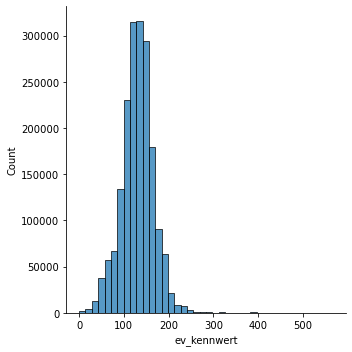

In [62]:
sns.displot(data=prediction_ev_kennwert, x='ev_kennwert', bins=40)

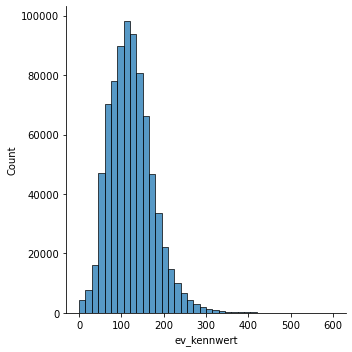

In [63]:
sns.displot(data=regression_ev_kennwert, x='ev_kennwert', bins=40)

In [64]:
prediction_ev_kennwert.shape[0] + regression_ev_kennwert.shape[0]

2651885

In [65]:
df.loc[idx, 'ev_kennwert'] = prediction_ev_kennwert.ev_kennwert

In [66]:

pd.DataFrame(df.isnull().sum(), columns=['null_counts']).sort_values(by='null_counts', ascending=False).head(20)

,null_counts
energieeffizienzklasse,2560651
anbieter,2501339
letzte_modernisierung,2095283
nutzflaeche,2021417
energieausweistyp,1828023
heizkosten,1827396
ausstattung,1550469
objektzustand,836019
kategorie_Wohnung,806731
heizungsart,589338


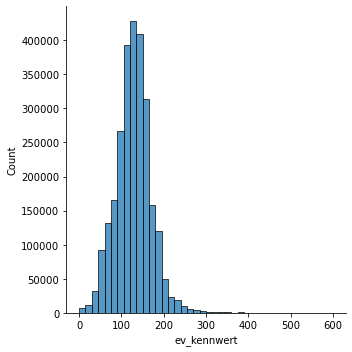

In [67]:
sns.displot(data=df, x='ev_kennwert', bins=40)

## Regression Energieausweistyp

In [68]:

columns_energieausweistyp = ['baujahr', 'City', 'year', 'ev_wwenthalten', 'wohnflaeche', 'etage',
       'anzahletagen', 'zimmeranzahl', 'schlafzimmer', 'badezimmer',
       'aufzug', 'balkon', 'energieausweistyp',
       'einbaukueche', 'gaestewc', 'garten',
       'keller', 'parkplatz', 'rollstuhlgerecht',
       'kategorie_Wohnung', 'objektzustand', 'heizungsart', 'heizkosten_in_wm_enthalten', 
       'Wärmezufuhr', 'Erdgas leicht', 'Erdgas schwer',
       'keine Information', 'Windenergie', 'Pellets', 'Solarenergie', 'Koks',
       'kombinierte erneuerbare Energie', 'Erdwärme', 'Bioenergie',
       'Wasserenergie', 'Nahwärme', 'Fernwärme', 'Holzschnitzel', 'Öl',
       'kombinierte regenerative Energie', 'Kohle',
       'kombinierte Fossilkraftstoffe', 'Gas', 'Holz', 'Heizdampf-Fernwärme',
       'thermische Umweltenergie', 'Flüssiggas', 'kombinierte Bio Energie',
       'Elektro']

In [69]:
regression_energieausweis = df[columns_energieausweistyp]

In [70]:
regression_energieausweis.energieausweistyp = regression_energieausweis.energieausweistyp.map({'Energieverbrauchskennwert': 1, 'Endenergiebedarf': 2})

/Users/florian/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [71]:
regression_energieausweis.energieausweistyp.value_counts()


1.0    534310
2.0    289552
Name: energieausweistyp, dtype: int64

In [72]:
regression_energieausweis.dropna(subset=['energieausweistyp'], inplace=True)

<ipython-input-72-df5b6255e969>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_energieausweis.dropna(subset=['energieausweistyp'], inplace=True)


In [73]:
X, y = clean_data(regression_energieausweis, 'energieausweistyp')

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [76]:
X.sum().abs().sort_values(ascending=False)

year                       1.660867e+09
baujahr                    1.617548e+09
wohnflaeche                5.761956e+07
schlafzimmer               3.645690e+07
badezimmer                 2.659172e+07
                               ...     
Wasserenergie              8.000000e+00
kombinierte Bio Energie    5.000000e+00
Windenergie                2.000000e+00
Koks                       2.000000e+00
City_nan                   0.000000e+00
Length: 95, dtype: float64

In [107]:
%%time
clf = DecisionTreeClassifier(min_samples_split=20, max_depth=1000)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(accuracy_score(y_test, prediction))

0.8282789049176746
CPU times: user 12 s, sys: 844 ms, total: 12.8 s
Wall time: 13.2 s


In [112]:
pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False).head(20)

,importance
baujahr,0.370638
year,0.108664
wohnflaeche,0.090590
anzahletagen,0.036241
etage,0.025203
ev_wwenthalten,0.023969
badezimmer,0.017118
zimmeranzahl,0.015993
schlafzimmer,0.014559
objektzustand_nan,0.013296


### Fill Energieausweistyp with predictions

In [134]:
prediction_energieausweis = df[columns_energieausweistyp]

In [135]:
prediction_energieausweis = prediction_energieausweis[prediction_energieausweis.energieausweistyp.isnull()]

In [136]:
X_pred, _ = clean_data(prediction_energieausweis, 'energieausweistyp')

In [137]:
prediction = clf.predict(X_pred)

In [138]:
prediction_energieausweis.energieausweistyp = prediction

In [139]:
idx = prediction_energieausweis.index

In [140]:
df.loc[idx, 'energieausweistyp'] = prediction_energieausweis.energieausweistyp

In [141]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651885 entries, 0 to 2651884
Data columns (total 73 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   obid                              2651885 non-null  int64         
 1   mietekalt                         2651885 non-null  float64       
 2   nebenkosten                       2490467 non-null  float64       
 3   heizkosten                        824489 non-null   float64       
 4   baujahr                           2651885 non-null  float64       
 5   letzte_modernisierung             556602 non-null   float64       
 6   wohnflaeche                       2651885 non-null  float64       
 7   nutzflaeche                       630468 non-null   float64       
 8   etage                             2651885 non-null  float64       
 9   anzahletagen                      2651885 non-null  float64       
 10  zimmeranzahl      

In [147]:
df.energieausweistyp = df.energieausweistyp.astype(int)

In [146]:
df.energieausweistyp.value_counts()

1    1959867
2     692018
Name: energieausweistyp, dtype: int64

In [149]:
df.energieausweistyp = df.energieausweistyp.map({1: 'Energieverbrauchskennwert', 2: 'Endenergiebedarf'})

In [150]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651885 entries, 0 to 2651884
Data columns (total 73 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   obid                              2651885 non-null  int64         
 1   mietekalt                         2651885 non-null  float64       
 2   nebenkosten                       2490467 non-null  float64       
 3   heizkosten                        824489 non-null   float64       
 4   baujahr                           2651885 non-null  float64       
 5   letzte_modernisierung             556602 non-null   float64       
 6   wohnflaeche                       2651885 non-null  float64       
 7   nutzflaeche                       630468 non-null   float64       
 8   etage                             2651885 non-null  float64       
 9   anzahletagen                      2651885 non-null  float64       
 10  zimmeranzahl      

In [153]:
df.energieausweistyp.value_counts(dropna=False, normalize=True)

Energieverbrauchskennwert    0.739047
Endenergiebedarf             0.260953
Name: energieausweistyp, dtype: float64

In [154]:
df.to_pickle('data/rent_regression_done.pkl')